# Having sentiment and technical indicators in the state representation notebook

In this particular notebook, we added eight different technical indicators and sentiment data into the state representation, enabling the agent to choose the best action based on the current state. Additionally, we used 14 as the window size and then split the dataset into two groups: training and testing. We trained the agent for 250,000 timesteps, equivalent to 117 episodes. At the end, we evaluated the agent's performance based on the average total reward and average total profit gained after a 10-episode evaluation on unseen data (testing data).

## Sentiment and technical indicators in state

### Pip Install Commands

In [1]:
!pip install gymnasium gym-anytrading pandas matplotlib stable-baselines3[extra] finta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_

### Libraries

In [2]:
import gymnasium as gym
import gym_anytrading
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions

from stable_baselines3 import DQN
from stable_baselines3 import A2C
from stable_baselines3 import PPO



from gym_anytrading.envs import StocksEnv
from finta import TA






### Const Values

In [3]:
WINDOW_SIZE = 14
DATASET_PATH = '/content/processed_TSLA.csv'


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Methods

add_signals() is a method where we can include the components we want to have in the state representation. So here we are adding following components into the state:

 1. Low
2. High
3. Close
4. Sentiment
5. SMA
6. RSI
7. MOM
8. OBV
9. EMA
10. Stochastic oscillator
11. AD
12. ROC

In [ ]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    diff = np.insert(np.diff(prices), 0, 0)
    signal_features = env.df.loc[:, ['Low','High','Close','Sentiment','SMA', 'RSI', 'MOM', 'OBV', 'EMA', 'Stochastic oscillator', 'AD', 'ROC']].to_numpy()[start:end]
    # Reshape diff to (282, 1)
    diff_reshaped = diff.reshape(len(diff), 1)

    # Concatenate along the second axis (columns)
    signal_features = np.concatenate((signal_features, diff_reshaped), axis=1)


    return prices, signal_features

### Code

Read the dataset and preprocess it

In [4]:
df = pd.read_csv(DATASET_PATH)

Change the type of `Date` column to datetime

In [5]:
df['Date'] = pd.to_datetime(df.Date)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment
0,0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,1
1,1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0
2,2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0
3,3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,1
4,4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,-1


Make the `Date` column an index

In [7]:
df.set_index('Date', inplace=True)

Sort it by index

In [8]:
df.sort_index(inplace=True)

In [9]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,,
2010-06-29,0,3.800,5.000,3.508,4.778,4.778,93831500,1
2010-06-30,1,5.158,6.084,4.660,4.766,4.766,85935500,0
2010-07-01,2,5.000,5.184,4.054,4.392,4.392,41094000,0
2010-07-02,3,4.600,4.620,3.742,3.840,3.840,25699000,1
2010-07-06,4,4.000,4.000,3.166,3.222,3.222,34334500,-1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2956 non-null   int64  
 1   Open        2956 non-null   float64
 2   High        2956 non-null   float64
 3   Low         2956 non-null   float64
 4   Close       2956 non-null   float64
 5   Adj Close   2956 non-null   float64
 6   Volume      2956 non-null   int64  
 7   Sentiment   2956 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 207.8 KB


Calculate the technical indicator using `finta` package and store the resent in the corresponding column in the dataset

In [11]:
df['SMA'] = TA.SMA(df, WINDOW_SIZE)
df['RSI'] = TA.RSI(df, WINDOW_SIZE)
df['MOM'] = TA.MOM(df, WINDOW_SIZE)
df['OBV'] = TA.OBV(df,'close')
df['EMA'] = TA.EMA(df, WINDOW_SIZE)
df['Stochastic oscillator'] = TA.AO(df,WINDOW_SIZE)
df['AD'] = TA.ADL(df)
df['ROC'] = TA.ROC(df,WINDOW_SIZE)
df.fillna(0, inplace=True)

Drop `Unnamed: 0` column

In [12]:
df.drop(columns='Unnamed: 0', inplace=True)

In [13]:
df.head(50)

,Open,High,Low,Close,Adj Close,Volume,Sentiment,SMA,RSI,MOM,OBV,EMA,Stochastic oscillator,AD,ROC
Date,,,,,,,,,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,1,0.000000,0.000000,0.000,0.0,4.778000,0.000000,6.590845e+07,0.000000
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0,0.000000,0.000000,0.000,-85935500.0,4.771571,0.000000,-7.233279e+06,0.000000
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0,0.000000,0.000000,0.000,-127029500.0,4.626574,0.000000,-2.374361e+07,0.000000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,1,0.000000,0.000000,0.000,-152728500.0,4.385939,0.000000,-4.370570e+07,0.000000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,-1,0.000000,0.000000,0.000,-187063000.0,4.082269,0.000000,-7.342934e+07,0.000000
2010-07-07,3.280,3.326,2.996,3.160,3.160,34608500,0,0.000000,0.000000,0.000,-221671500.0,3.868872,0.000000,-7.363909e+07,0.000000
2010-07-08,3.228,3.504,3.114,3.492,3.492,38557000,0,0.000000,20.112173,0.000,-183114500.0,3.789457,0.000000,-3.745482e+07,0.000000
2010-07-09,3.516,3.580,3.310,3.480,3.480,20253000,0,0.000000,19.955945,0.000,-203367500.0,3.728932,0.000000,-3.220405e+07,0.000000
2010-07-12,3.590,3.614,3.400,3.410,3.410,11012500,1,0.000000,19.027444,0.000,-214380000.0,3.670209,0.000000,-4.218734e+07,0.000000


Create a class and inherit it from StockEnv and update the _process_data method with add_signals 

In [15]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

Split the dataset

In [16]:
train_df = df.loc[df.index < '2019-01-01']
test_df = df.loc[df.index >= '2019-01-01']

print('train_df: ',len(train_df))
print('test_df: ',len(test_df))

train_df:  2142
test_df:  814


In [ ]:
train_df.shape

(2142, 15)

Create an environment and provide training data

In [17]:
env = MyCustomEnv(df=train_df, frame_bound=(WINDOW_SIZE, len(train_df)), window_size=WINDOW_SIZE)

A single vector representing the state.

In [18]:
env.signal_features[:1,:]

array([[3.50800000e+00, 5.00000000e+00, 4.77800000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.77800000e+00, 0.00000000e+00, 6.59084531e+07, 0.00000000e+00,
        0.00000000e+00]])

In [ ]:
env.action_space

Discrete(2)

Discrete: describes a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take. Values can be shifted to {a, a+1, …, a+n-1} using an optional argument.

In [ ]:
env.action_space.sample()

0

Sell = 0

Buy = 1

In [ ]:
env.observation_space

Box(-10000000000.0, 10000000000.0, (14, 13), float32)

Box: describes an n-dimensional continuous space. It’s a bounded space where we can define the upper and lower limits which describe the valid values our observations can take.



In [ ]:
env.observation_space.sample()

array([[ 9.1338824e+09, -1.1620742e+09, -5.1746880e+07, -6.1013919e+09,
        -7.5871140e+09, -4.7900703e+09,  2.1182952e+08, -5.0698092e+09,
        -3.2234340e+09,  9.2608512e+09,  8.0128850e+09,  9.2194867e+09,
         2.3112128e+09],
       [-4.9289062e+09,  1.7455715e+09, -8.4532598e+09,  2.8223217e+09,
        -4.0703478e+09, -4.8936714e+09, -9.0314916e+09, -2.8120686e+09,
         4.7545933e+09, -3.8679354e+08, -4.5802363e+09,  7.3119508e+09,
         5.9177037e+09],
       [-1.5998246e+09, -1.5862321e+09, -8.0364739e+09, -3.1036534e+09,
         5.3449288e+09, -7.7119503e+09, -6.4260321e+09, -4.4187104e+08,
        -9.5617352e+09,  2.7608709e+09, -8.4439378e+09, -8.2680320e+09,
         5.1930936e+09],
       [-5.9861012e+09, -7.3901384e+09, -4.3759130e+09,  3.0024998e+09,
        -4.0649395e+09, -7.3441935e+09, -9.3560381e+09, -4.4381471e+09,
        -4.9170038e+09,  9.0366403e+09, -8.7757363e+09, -2.7611095e+09,
        -2.9091589e+09],
       [ 3.6735808e+08,  2.6591470e+

Create the environment and do some random action on it

info: {'total_reward': 45.983995000000014, 'total_profit': 0.004284681837425818, 'position': <Positions.Short: 0>}


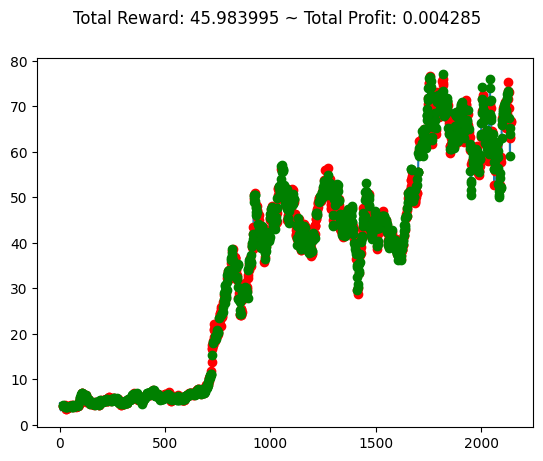

In [19]:

observation = env.reset(seed=2024)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

create and training the A2C model on 250000 timesteps

In [20]:
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=250000)

Streaming output truncated to the last 5000 lines.
|    value_loss         | 3.88e-05 |
------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.13e+03  |
|    ep_rew_mean        | 28.3      |
| time/                 |           |
|    fps                | 467       |
|    iterations         | 20700     |
|    time_elapsed       | 221       |
|    total_timesteps    | 103500    |
| train/                |           |
|    entropy_loss       | -0.113    |
|    explained_variance | -11.7     |
|    learning_rate      | 0.0007    |
|    n_updates          | 20699     |
|    policy_loss        | -0.000373 |
|    value_loss         | 0.000183  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 2.13e+03  |
|    ep_rew_mean        | 28.3      |
| time/                 |           |
|    fps                | 468       |
|

Save model

In [ ]:
# model.save('ppo_1000000_15_senti')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# del model

Load model

In [ ]:
# model = A2C.load('/content/ppo_1000000_15_senti.zip')

Evaluate the model using new environment which will have the testing data, for 10 episodes.

In [22]:
env = MyCustomEnv(df=test_df, frame_bound=(WINDOW_SIZE, len(test_df)), window_size=WINDOW_SIZE)

avg_reward = []
avg_profit = []

for i in range(10):

  observation, info = env.reset(seed=2024)
  while True:
      # print('ob',observation)
      action = model.predict(observation)
      # print('action',action[0])
      observation, reward, terminated, truncated, info = env.step(action[0])
      done = terminated or truncated

      # env.render()
      if done:
          print("info:", info)
          avg_reward.append(info['total_reward'])
          avg_profit.append(info['total_profit'])
          break

  # plt.cla()
  # env.unwrapped.render_all()
  # plt.show()

print('\nAverage reward: ', np.mean(avg_reward))
print('\nAverage profit: ', np.mean(avg_profit))

info: {'total_reward': 238.890042, 'total_profit': 6.60804850122583, 'position': <Positions.Long: 1>}
info: {'total_reward': 240.14400200000006, 'total_profit': 5.480918151463863, 'position': <Positions.Long: 1>}
info: {'total_reward': 263.57401000000004, 'total_profit': 7.226035541962915, 'position': <Positions.Long: 1>}
info: {'total_reward': 930.114002, 'total_profit': 4.264893031202994, 'position': <Positions.Short: 0>}
info: {'total_reward': 201.46998100000002, 'total_profit': 3.1010433325732945, 'position': <Positions.Long: 1>}
info: {'total_reward': 221.73801400000002, 'total_profit': 3.0858542395318462, 'position': <Positions.Long: 1>}
info: {'total_reward': 665.492029, 'total_profit': 5.111351318477221, 'position': <Positions.Long: 1>}
info: {'total_reward': 745.9840330000001, 'total_profit': 5.868170204394046, 'position': <Positions.Long: 1>}
info: {'total_reward': 956.5240050000001, 'total_profit': 7.090057023271257, 'position': <Positions.Long: 1>}
info: {'total_reward': 23